In [44]:
from iris.analysis.cartography import rotate_pole
import numpy

%matplotlib inline
import matplotlib.pyplot as plt

In [49]:
def rotate_equator(pole_lon, pole_lat):
    """Rotate the equator."""
    
    print "Pole lon =", pole_lon
    print "Pole lat =", pole_lat
    
    orig_lons = numpy.arange(-180, 180, 1)
    orig_lats = numpy.zeros(test_lons.shape)
    
    new_lons, new_lats = rotate_pole(test_lons, test_lats, pole_lon, pole_lat)
    
    plt.plot(orig_lons, orig_lats)
    plt.plot(new_lons, new_lats)
    plt.show()

Pole lon = 270
Pole lat = 30


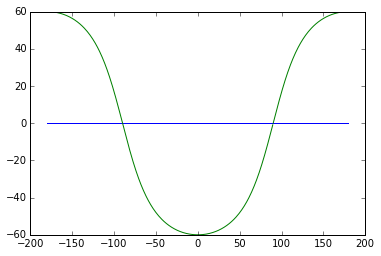

Pole lon = 35
Pole lat = 50


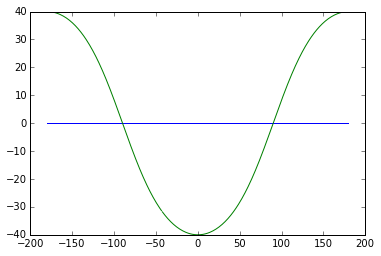

In [50]:
rotate_equator(270, 30)
rotate_equator(35, 50)